# PM10 Data Report

After downloading the data and preparing it, we obtained a PM10 dataset with daily averages for processing, which is the one used for this report.

The first section of code contains the libraries and some helper functions for plotting and processing the data.

Second section contains data preparation for the PM10 dataset.

Third section provides a plot of the exceedence rate of each sensor for each month to check temporal and spatial variability.

Fourth section provides some interpolations to see the spatial variability and the effect of different interpolation methods in the pollution maps produced from the data.

## Section 1 - Imports and helper functions

In [3]:
import sys
sys.path.append("../../../..")

# Import the necessary libraries
from datetime import date
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

#This is a interpolation module that uses scipy interpolation methods.
from modules import interpolation_module as interp

2025-03-01 22:39:12.030675: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-01 22:39:12.031853: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-01 22:39:12.054097: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-01 22:39:12.054584: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-01 22:39:12.444516: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [4]:
#Helper function for plotting DataFrames
def show_plot(df, x_col, y_col, name="Unnamed Plot", limits=[], print=False):
    if type(df) != list:
        df = [df]
        x_col = [x_col]
        y_col = [y_col]
        name = [name]
    
    fig = go.Figure()
    for i, single_df in enumerate(df):
        x = single_df[x_col[i]]
        y = single_df[y_col[i]]
        fig_name = name[i]
        if print:
            fig.add_trace(go.Scatter(x=x, y=y, mode='lines+markers',line=dict(width=10),marker_size=20,name=fig_name))
        else:
            fig.add_trace(go.Scatter(x=x, y=y, mode='lines+markers',name=fig_name))
            
    
    if len(limits) > 0:
        for limit in limits:
            thr = limit['thr']
            name = limit['name']
            #fig.add_trace(trace)
            fig.add_hline(y=thr, line_width=2, line_dash="dot", line_color="black", annotation_text=name)
    
    # Set white background color
    if print:
        fig.update_layout(
            width=3600,
            height=1600,
            font=dict(
                size=50,
            ),
            plot_bgcolor='white',   # Background of the plot area (white)
            paper_bgcolor='white',  # Background of the entire figure (white)
            xaxis=dict(showgrid=True, gridcolor='lightgray',title='Date'),  # Keep grid lines
            yaxis=dict(showgrid=True, gridcolor='lightgray',title='μg/m3')   # Keep grid lines
        )
    
    fig.show()

In [5]:
#function to import the csv file and do some preprocessing
def import_df(path, start_year, end_year, date_format="%Y-%m-%d", date_column="date"):
    df = pd.read_csv(path, index_col = 0)
    if date_format is not None and date_column is not None:
        df[date_column] = pd.to_datetime(df[date_column],  format=date_format)
    df = df.loc[
        (df['date'].dt.year >= start_year) &
        (df['date'].dt.year <= end_year)
    ]
    #df = df.replace(-9999.0, np.nan).dropna()
    return df

## Section 2 - Data Preparation

Here we set the daily theshold according to EU regulations. The regulation states that for PM10 the daily average threshold should be a maximum of 50 µg/m3.

Then, data of PM10 daily avergaes is imported as a DataFrame and the dates are converted to datetime for further processing and filter.

A new column ("exceed") is added to the DataFrame as a binary classification to determine if the value at a set date exceedes the daily threshold.

From the data, we also can see that the PM10 data ranges from February 1998 to February 2023. In total, 9122 days.

In [6]:
"""
Pollutant   daily     exceedances per year
PM10        50        35
"""
pm10_daily_threshold = 45 #ug/m3
pm10_yearly_threshold = 20

# Using the row daily PM10 data.
pm10_file_path = "../../data/milano_pollutant_data/pm10_daily.csv"
start_year = 1998
end_year = 2023
pm10_data = import_df(pm10_file_path, start_year, end_year)

In [7]:
#Add binary column for defining if a day exceeds the threshold [0: no, 1: yes]
pm10_data['exceed'] = np.where(pm10_data['value'].gt(pm10_daily_threshold), 1, 0)

In [8]:
pm10_data = pm10_data.sort_values('date')
unique_days = pm10_data.date.unique()
initial_day = unique_days[0]
final_day = unique_days[-1]
total_days = (final_day - initial_day).astype("timedelta64[D]") #9122 days
print(f'Initial Date: {initial_day}')
print(f'Final Date: {final_day}')
print(f'Total Days: {total_days}')

Initial Date: 1998-02-14T00:00:00.000000000
Final Date: 2023-12-31T00:00:00.000000000
Total Days: 9451 days


In [9]:
pm10_data.describe()

,sensor_id,lat,lng,value,exceed
count,68354.000000,68354.000000,68354.000000,68354.000000,68354.000000
mean,8693.430421,45.502559,9.161780,39.132020,0.289742
std,2896.203938,0.044320,0.246635,27.811292,0.453646
min,6905.000000,45.462416,8.736497,0.000000,0.000000
25%,6908.000000,45.470499,8.880210,20.000000,0.000000
50%,6956.000000,45.483630,9.197460,31.000000,0.000000
75%,10320.000000,45.526551,9.327360,50.000000,1.000000
max,20429.000000,45.613692,9.515980,304.000000,1.000000


In [10]:
pm10_data

,date,sensor_id,lat,lng,value,exceed
0,1998-02-14,6905,45.473226,9.222315,133.0,1
1,1998-02-15,6905,45.473226,9.222315,80.0,1
2,1998-02-16,6905,45.473226,9.222315,104.0,1
3,1998-02-17,6905,45.473226,9.222315,39.0,0
4,1998-02-18,6905,45.473226,9.222315,58.0,1
...,...,...,...,...,...,...
2164,2023-12-31,6956,45.463347,9.195325,36.0,0
5001,2023-12-31,20428,45.526473,9.515980,39.0,0
2868,2023-12-31,10273,45.478996,9.235491,44.0,0
3582,2023-12-31,10320,45.470499,9.197460,46.0,1


## Section 3 - Exceedence rate

Here we calculate the exceedence rate for each month of each year and for each sensor. The exceedence rate is the percentage of days in a month that a sensor reports that the PM10 threshold has been exceeded. 

This gives us an idea of which months are more polluted in terms of PM10 and also allows us to observe the variability in each sensor in the entire time range. With this, it is possible to check if the exceedence rates in different sensors are similar or different in the same month, meaning that there is also spatial variability in the PM10 pollution.

In [11]:
#Calculate exceedance rate
pm10_data_per_month = pm10_data.copy()
pm10_data_per_month = pm10_data_per_month.assign(year=pm10_data_per_month['date'].dt.year, month=pm10_data_per_month['date'].dt.month)
pm10_data_per_month = pm10_data_per_month.drop(['date'], axis=1)
pm10_data_per_month = pm10_data_per_month.groupby(['year', 'month', 'lat', 'lng', 'sensor_id']).agg(exceed=('exceed', 'sum'), days_with_data=('value', 'count'), mean_value=('value', 'mean'))
#pm10_data_per_month = pm10_data_per_month.rename(columns={"value": "days_with_data"})
pm10_data_per_month["exceeded_rate"] = (pm10_data_per_month["exceed"] / pm10_data_per_month["days_with_data"] * 100)
pm10_data_per_month = pm10_data_per_month.reset_index()
pm10_data_per_month['t'] = pm10_data_per_month['year'].astype(str) + '-' + pm10_data_per_month['month'].astype(str)
pm10_data_per_month

,year,month,lat,lng,sensor_id,exceed,days_with_data,mean_value,exceeded_rate,t
0,1998,2,45.462416,8.880210,6912,4,4,85.750000,100.000000,1998-2
1,1998,2,45.473226,9.222315,6905,11,13,98.076923,84.615385,1998-2
2,1998,2,45.483630,9.327360,6908,6,7,95.000000,85.714286,1998-2
3,1998,3,45.462416,8.880210,6912,18,27,52.740741,66.666667,1998-3
4,1998,3,45.473226,9.222315,6905,21,29,57.241379,72.413793,1998-3
...,...,...,...,...,...,...,...,...,...,...
2405,2023,12,45.478996,9.235491,10273,10,29,40.206897,34.482759,2023-12
2406,2023,12,45.483630,9.327360,6908,11,29,40.344828,37.931034,2023-12
2407,2023,12,45.496316,9.190934,20429,15,31,44.025806,48.387097,2023-12
2408,2023,12,45.526473,9.515980,20428,9,31,35.677419,29.032258,2023-12


In [12]:
pm10_data_per_month.describe()

,year,month,lat,lng,sensor_id,exceed,days_with_data,mean_value,exceeded_rate
count,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000
mean,2012.256432,6.522822,45.503260,9.162428,8688.956432,8.217842,28.362656,39.194019,28.971206
std,6.596901,3.450128,0.044891,0.248776,2885.850587,8.433232,4.007622,19.948159,29.283064
min,1998.000000,1.000000,45.462416,8.736497,6905.000000,0.000000,1.000000,8.000000,0.000000
25%,2007.000000,4.000000,45.470499,8.880210,6908.000000,0.000000,28.000000,24.008065,0.000000
50%,2013.000000,7.000000,45.483630,9.197460,6956.000000,5.000000,30.000000,33.959742,19.354839
75%,2018.000000,10.000000,45.526551,9.327360,10320.000000,15.000000,31.000000,50.179644,53.333333
max,2023.000000,12.000000,45.613692,9.515980,20429.000000,31.000000,31.000000,135.709677,100.000000


In [13]:
pm10_data_per_month.groupby(['month']).mean()

/tmp/ipykernel_35600/3028039518.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pm10_data_per_month.groupby(['month']).mean()


,year,lat,lng,sensor_id,exceed,days_with_data,mean_value,exceeded_rate
month,,,,,,,,
1,2012.532995,45.503633,9.162834,8688.908629,19.116751,28.796954,65.081757,66.466249
2,2012.315000,45.503175,9.162541,8662.200000,15.120000,26.625000,60.034830,57.314694
3,2012.356784,45.502620,9.160804,8671.020101,11.130653,29.457286,44.104042,37.985818
4,2012.273632,45.503055,9.162904,8670.213930,3.860697,28.512438,29.181386,13.677549
5,2012.253731,45.503488,9.166743,8653.074627,1.691542,28.925373,24.379964,6.186487
6,2012.258706,45.503680,9.164465,8687.328358,1.676617,26.920398,25.663821,6.235906
7,2012.233831,45.503786,9.160466,8672.159204,1.044776,28.422886,24.362703,3.886623
8,2012.208955,45.503604,9.161967,8704.328358,0.631841,28.502488,21.671686,2.315256
9,2012.178218,45.503506,9.162786,8695.435644,3.534653,27.485149,28.845536,12.942590


mean_value    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

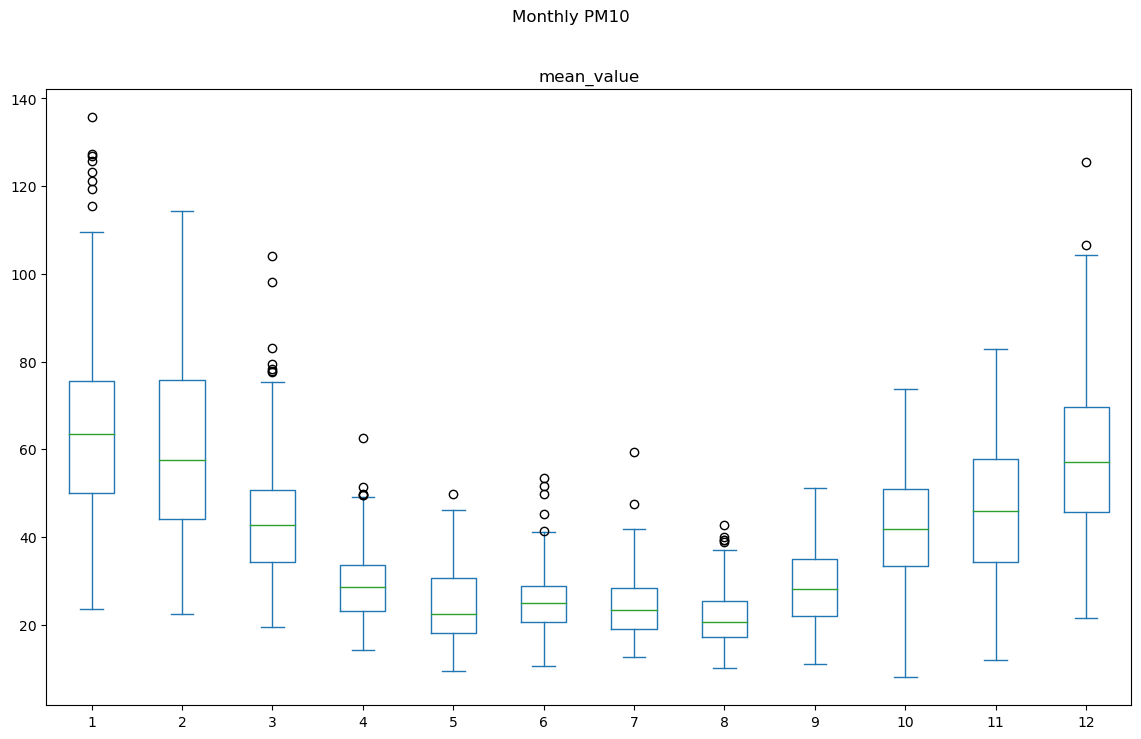

In [18]:
pm10_data_per_month.plot.box(column="mean_value", by="month", figsize=(14, 8), title='Monthly PM10')

mean_value    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

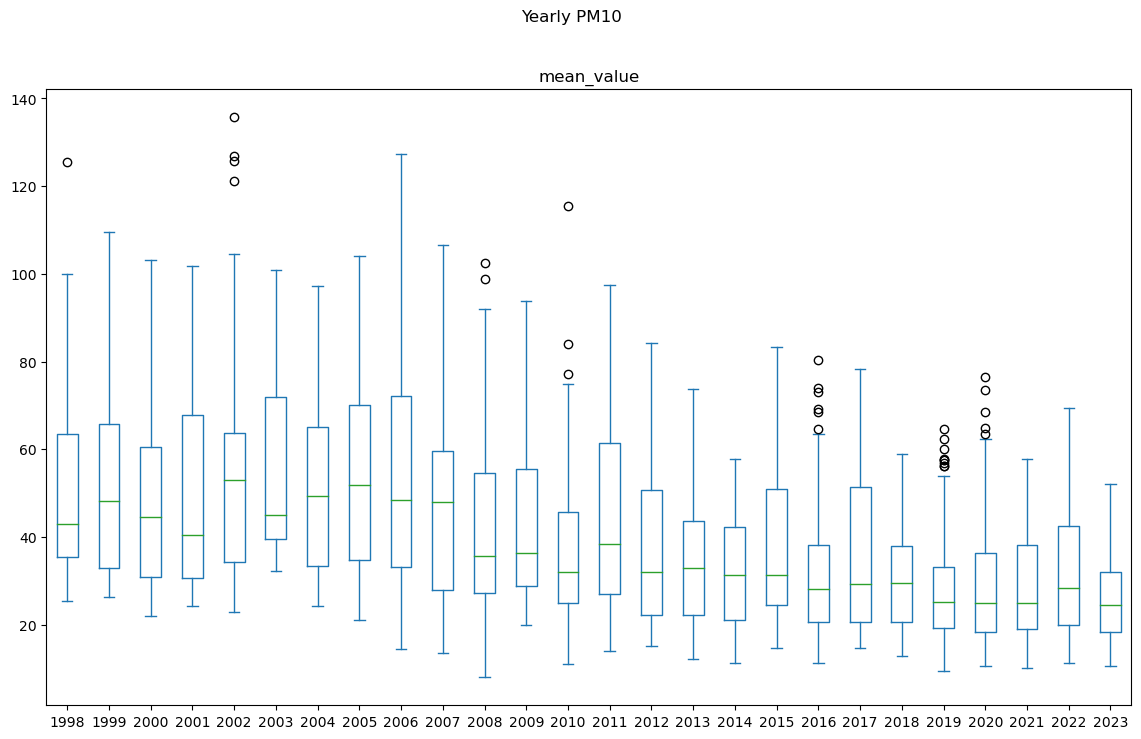

In [15]:
pm10_data_per_month.plot.box(column="mean_value", by="year", figsize=(14, 8), title='Yearly PM10')

mean_value    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

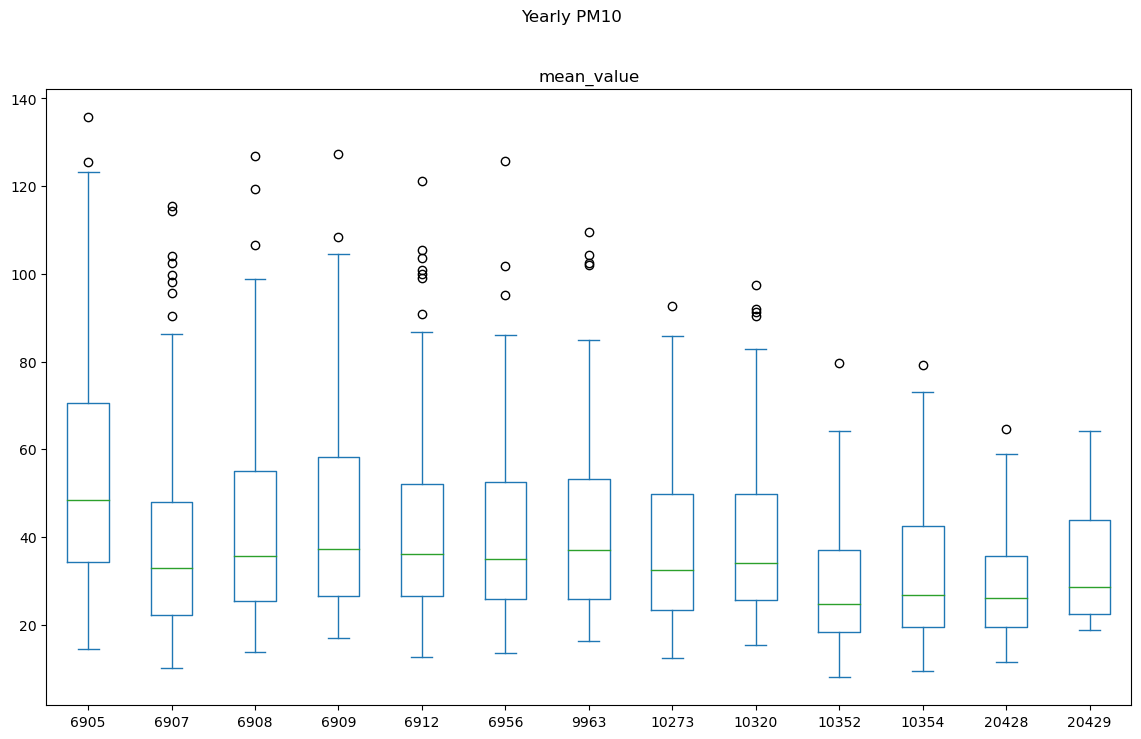

In [16]:
pm10_data_per_month.plot.box(column="mean_value", by="sensor_id", figsize=(14, 8), title='Yearly PM10')

In [10]:
names = {
    '6905':'Milano v.Juvara',
    '6907':'Trezzo sull\'Adda v.Nenni',
    '6908':'Pioltello Limito',
    '6909':'Arese v. Matteotti',
    '6912':'Magenta v. F. Turati',
    '6956':'Milano Verziere',
    '9963':'Cassano d\'Adda v.di Vona',
    '10273':'Milano Pascal Città Studi',
    '10320':'Milano v.Senato',
    '10352':'Turbigo vicolo dello sport',
    '10354':'Robecchetto con Induno v. Pertini',
    '20035':'Milano Verziere',
    '20428':'Cassano d\'Adda 2-v.Milano',
    '20429':'Milano v.Marche',
    '20430':'Milano v.Marche',
}

In [11]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [20]:
list(pm10_data.sensor_id.unique())

[6905,
 6908,
 6912,
 6907,
 6956,
 6909,
 9963,
 10273,
 10320,
 10352,
 10354,
 20428,
 20429]

In [13]:
sensors = list(pm10_data.sensor_id.unique())
#sensors = [6905,6956,10273,10320,20035]
# Plot the exceedence rate per sensor too see if there is variation in time
plot_dfs = []
plot_names = []
for sensor in sensors:
    df_sensor = pm10_data_per_month.loc[pm10_data_per_month['sensor_id'] == sensor]
    plot_dfs.append(df_sensor.copy())
    plot_names.append(names.get(str(sensor)))

plot_columns_x = ['t'] * len(plot_dfs)
plot_columns_y = ['mean_value'] * len(plot_dfs)

show_plot(plot_dfs, plot_columns_x, plot_columns_y, name=plot_names, limits=[{'thr': 40, 'name':'Daily limit'}], print=False)

In [32]:
sensors = list(pm10_data.sensor_id.unique())
sensors = [6905,6956,10273,10320,20035]
# Plot the exceedence rate per sensor too see if there is variation in time
plot_dfs = []
plot_names = []
for sensor in sensors:
    df_sensor = pm10_data_per_month.loc[pm10_data_per_month['sensor_id'] == sensor]
    plot_dfs.append(df_sensor.copy())
    plot_names.append(names.get(str(sensor)))

plot_columns_x = ['t'] * len(plot_dfs)
plot_columns_y = ['mean_value'] * len(plot_dfs)
    
show_plot(plot_dfs, plot_columns_x, plot_columns_y, name=plot_names)

In [14]:
#Calculate exceedance rate
pm10_data_per_year = pm10_data.copy()
pm10_data_per_year = pm10_data_per_year.assign(year=pm10_data_per_year['date'].dt.year)
pm10_data_per_year = pm10_data_per_year.drop(['date'], axis=1)
pm10_data_per_year = pm10_data_per_year.groupby(['year', 'lat', 'lng', 'sensor_id']).agg(exceed=('exceed', 'sum'), days_with_data=('value', 'count'), mean_value=('value', 'mean'))
#pm10_data_per_month = pm10_data_per_month.rename(columns={"value": "days_with_data"})
pm10_data_per_year = pm10_data_per_year.reset_index()
#pm10_data_per_year['t'] = pm10_data_per_year['year'].astype(str) + '-' + pm10_data_per_year['month'].astype(str)
pm10_data_per_year

,year,lat,lng,sensor_id,exceed,days_with_data,mean_value
0,1998,45.462416,8.880210,6912,117,233,51.626609
1,1998,45.473226,9.222315,6905,141,292,55.376712
2,1998,45.483630,9.327360,6908,111,256,47.101562
3,1999,45.462416,8.880210,6912,124,315,49.346032
4,1999,45.473226,9.222315,6905,143,322,55.307453
...,...,...,...,...,...,...,...
203,2023,45.478996,9.235491,10273,44,357,26.518207
204,2023,45.483630,9.327360,6908,47,349,27.446991
205,2023,45.496316,9.190934,20429,57,356,29.928090
206,2023,45.526473,9.515980,20428,37,299,26.568562


In [15]:
pm10_data_per_year['exceed'] = np.where(pm10_data_per_year['mean_value'].gt(pm10_yearly_threshold), 1, 0)
pm10_data_per_year["exceeded_rate"] = (pm10_data_per_year["exceed"] / pm10_data_per_year["days_with_data"] * 100)
pm10_data_per_year

,year,lat,lng,sensor_id,exceed,days_with_data,mean_value,exceeded_rate
0,1998,45.462416,8.880210,6912,1,233,51.626609,0.429185
1,1998,45.473226,9.222315,6905,1,292,55.376712,0.342466
2,1998,45.483630,9.327360,6908,1,256,47.101562,0.390625
3,1999,45.462416,8.880210,6912,1,315,49.346032,0.317460
4,1999,45.473226,9.222315,6905,1,322,55.307453,0.310559
...,...,...,...,...,...,...,...,...
203,2023,45.478996,9.235491,10273,1,357,26.518207,0.280112
204,2023,45.483630,9.327360,6908,1,349,27.446991,0.286533
205,2023,45.496316,9.190934,20429,1,356,29.928090,0.280899
206,2023,45.526473,9.515980,20428,1,299,26.568562,0.334448


In [48]:
pm10_data_per_year.groupby(['year']).mean()

,lat,lng,sensor_id,exceed,days_with_data,mean_value,exceeded_rate
year,,,,,,,
1998,45.473091,9.143295,6908.333333,1.000000,260.333333,51.368295,0.387425
1999,45.473091,9.143295,6908.333333,1.000000,329.000000,50.803543,0.304578
2000,45.473091,9.143295,6908.333333,1.000000,335.333333,49.494768,0.298590
2001,45.499262,9.226667,6917.600000,1.000000,259.800000,56.239535,0.602861
2002,45.506624,9.202343,6916.166667,1.000000,341.000000,53.102477,0.294296
2003,45.506624,9.202343,6916.166667,1.000000,344.333333,54.792849,0.291004
2004,45.506624,9.202343,6916.166667,1.000000,343.666667,50.501225,0.295625
2005,45.506624,9.202343,6916.166667,1.000000,329.166667,54.339653,0.307038
2006,45.508536,9.246611,7351.428571,1.000000,328.285714,54.386077,0.306273


array([[<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'lng'}>],
       [<AxesSubplot:title={'center':'sensor_id'}>,
        <AxesSubplot:title={'center':'exceed'}>,
        <AxesSubplot:title={'center':'days_with_data'}>],
       [<AxesSubplot:title={'center':'mean_value'}>,
        <AxesSubplot:title={'center':'exceeded_rate'}>, <AxesSubplot:>]],
      dtype=object)

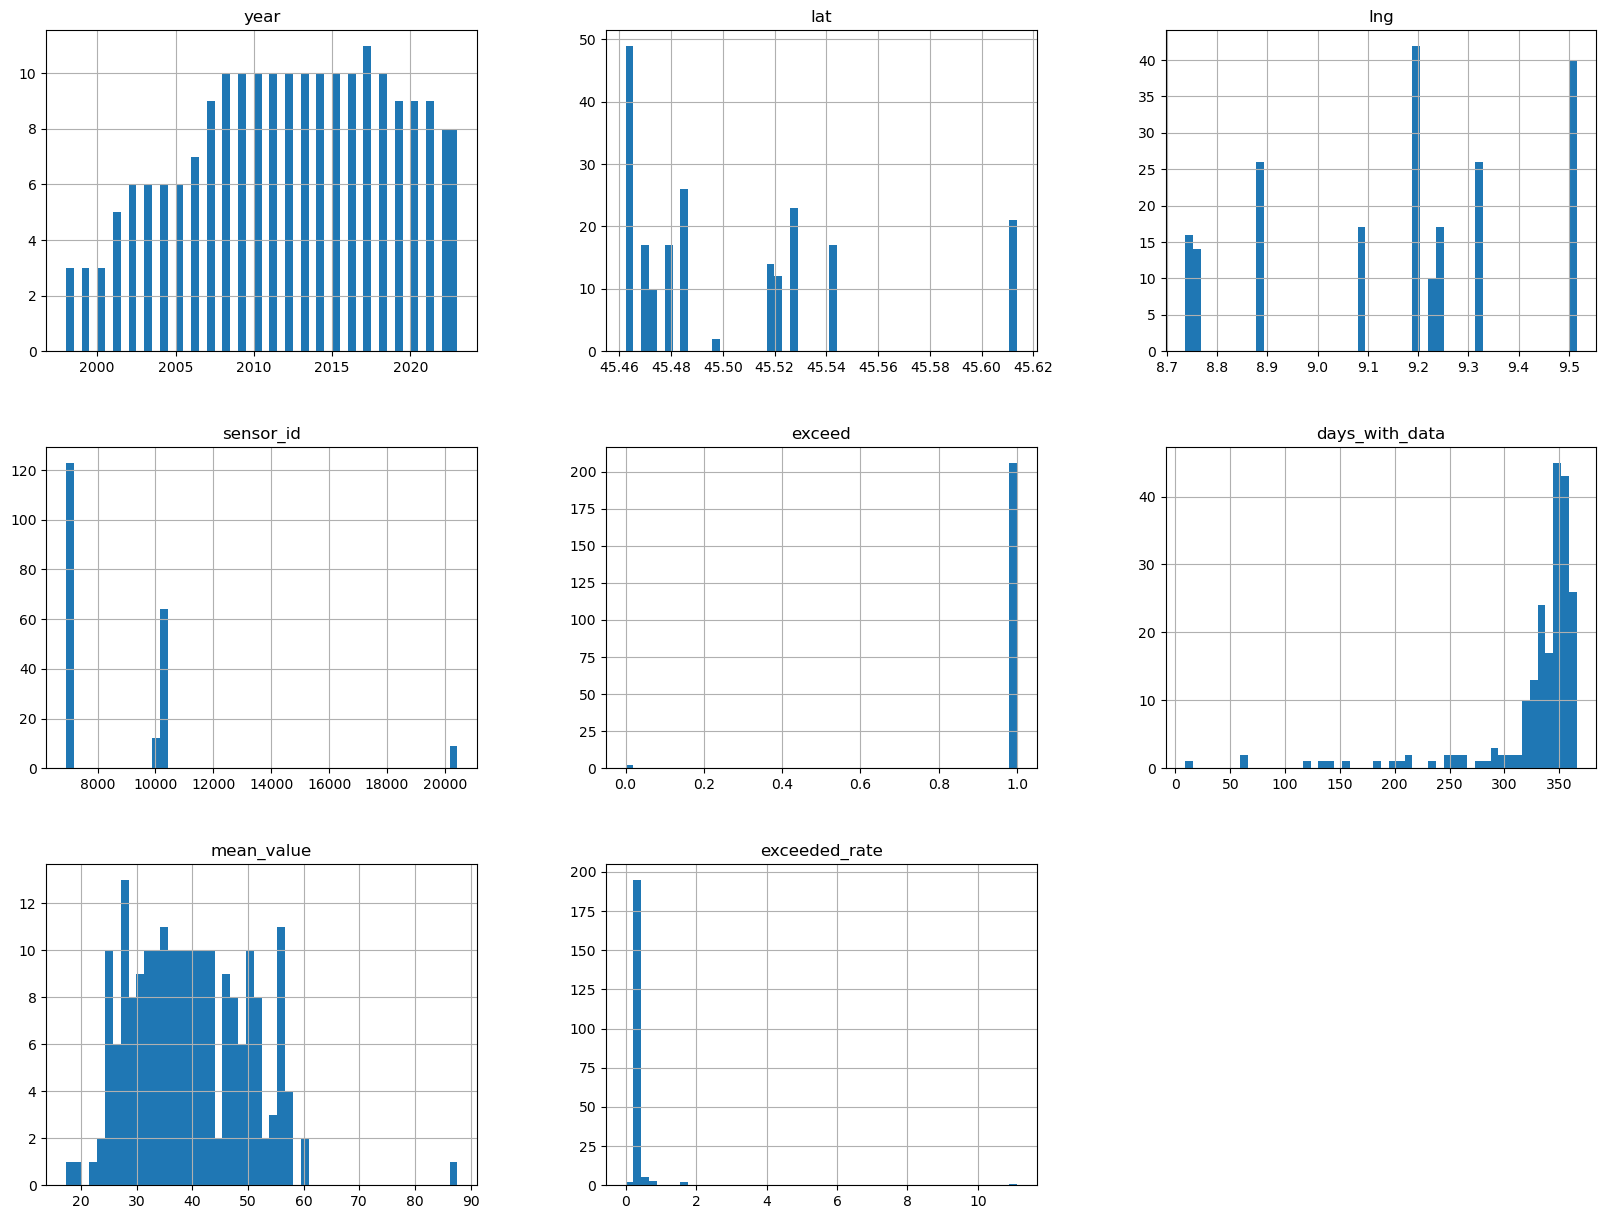

In [21]:
pm10_data_per_year.hist(bins=50, figsize=(20,15))

In [16]:
data_piece = pm10_data_per_year.loc[pm10_data_per_year['year'] >= 2010]

In [17]:
data_piece.sensor_id.unique()

array([ 6912,  6956, 10320, 10273,  6908, 10354,  9963, 10352,  6909,
        6907, 20428, 20429])

In [18]:
data_piece.describe()

,year,lat,lng,sensor_id,exceed,days_with_data,mean_value,exceeded_rate
count,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000
mean,2016.246269,45.505248,9.150202,9380.335821,0.985075,337.604478,33.785506,0.373375
std,3.957360,0.043434,0.265184,3392.673767,0.121709,41.728269,6.648294,0.936742
min,2010.000000,45.462416,8.736497,6907.000000,0.000000,9.000000,17.308458,0.000000
25%,2013.000000,45.470499,8.880210,6909.000000,1.000000,336.250000,28.510935,0.281690
50%,2016.000000,45.483630,9.197460,9963.000000,1.000000,347.000000,33.524359,0.287356
75%,2019.750000,45.526551,9.327360,10352.000000,1.000000,355.000000,38.402011,0.296736
max,2023.000000,45.613692,9.515980,20429.000000,1.000000,363.000000,57.666667,11.111111


In [19]:

sensors = list(pm10_data.sensor_id.unique())
sensors = [6905,6956,10273,10320,20035]
plot_dfs = []
plot_names = []
for sensor in sensors:
    df_sensor = pm10_data_per_year.loc[pm10_data_per_year['sensor_id'] == sensor]
    plot_dfs.append(df_sensor.copy())
    plot_names.append(names.get(str(sensor)))

plot_columns_x = ['year'] * len(plot_dfs)
plot_columns_y = ['mean_value'] * len(plot_dfs)
    
show_plot(plot_dfs, plot_columns_x, plot_columns_y, name=plot_names, limits=[{'thr': 20, 'name':'Yearly limit'}], print=False)

In [20]:

sensors = list(pm10_data.sensor_id.unique())
#sensors = [6905,6956,10273,10320,20035]
plot_dfs = []
plot_names = []
for sensor in sensors:
    df_sensor = pm10_data_per_year.loc[pm10_data_per_year['sensor_id'] == sensor]
    plot_dfs.append(df_sensor.copy())
    plot_names.append(names.get(str(sensor)))

plot_columns_x = ['year'] * len(plot_dfs)
plot_columns_y = ['mean_value'] * len(plot_dfs)
    
show_plot(plot_dfs, plot_columns_x, plot_columns_y, name=plot_names, limits=[{'thr': 20, 'name':'Yearly limit'}], print=False)

## Section 4 - Interpolation

Here we create a interpolation of the data in the entire comune of Milano using the available in-situ data from the stations for a specific month of the entire time range. We show only the results for January 2020 with Nearest Neighboors, Krigging, and with Inverse Distance Weighted interpolation methods.

In [13]:
# General variables
milano_shapefile_path = '../data/milano_final_shapefile/milano_metro.shp'
xdelta = 1000 #1000 meter separation for grid in x coordinates
ydelta = 1000 #1000 meter separation for grid in y coordinates

In [14]:
month_average_exceedence_rate = pm10_data_per_month.groupby(["month", "lat", "lng", "sensor_id"]).mean(numeric_only=True)
month_average_exceedence_rate = month_average_exceedence_rate.drop(columns=["days_with_data", "exceed", "year"])
month_average_exceedence_rate = month_average_exceedence_rate.reset_index()
month_average_exceedence_rate

,month,lat,lng,sensor_id,mean_value,exceeded_rate
0,1,45.462416,8.880210,6912,69.434968,66.206575
1,1,45.463347,9.195325,6956,67.097925,63.694263
2,1,45.470499,9.197460,10320,63.112899,62.441470
3,1,45.473226,9.222315,6905,97.111878,81.601647
4,1,45.478996,9.235491,10273,61.098672,61.090394
...,...,...,...,...,...,...
139,12,45.520009,9.512221,9963,61.142106,59.818739
140,12,45.526473,9.515980,20428,47.049462,40.788530
141,12,45.526551,8.736497,10352,46.469432,38.364646
142,12,45.543433,9.080726,6909,70.914953,66.676711


Month 1
Creating an interpolation with the Inverse Distance Weighted method
Plotting the results...


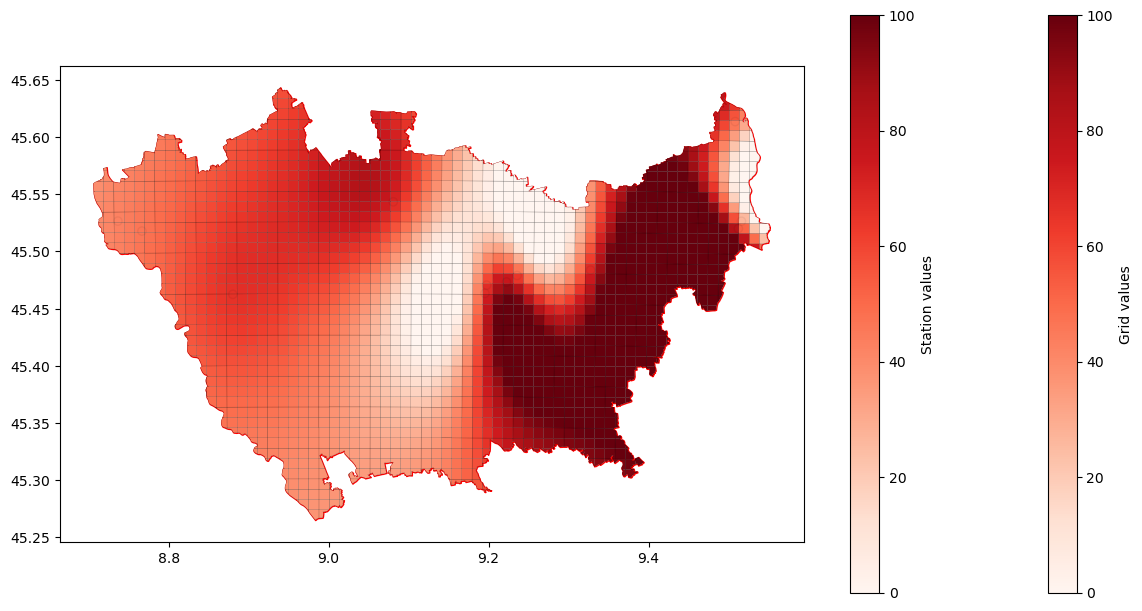

----------------------------------------------------------------------
Month 2
Creating an interpolation with the Inverse Distance Weighted method
Plotting the results...


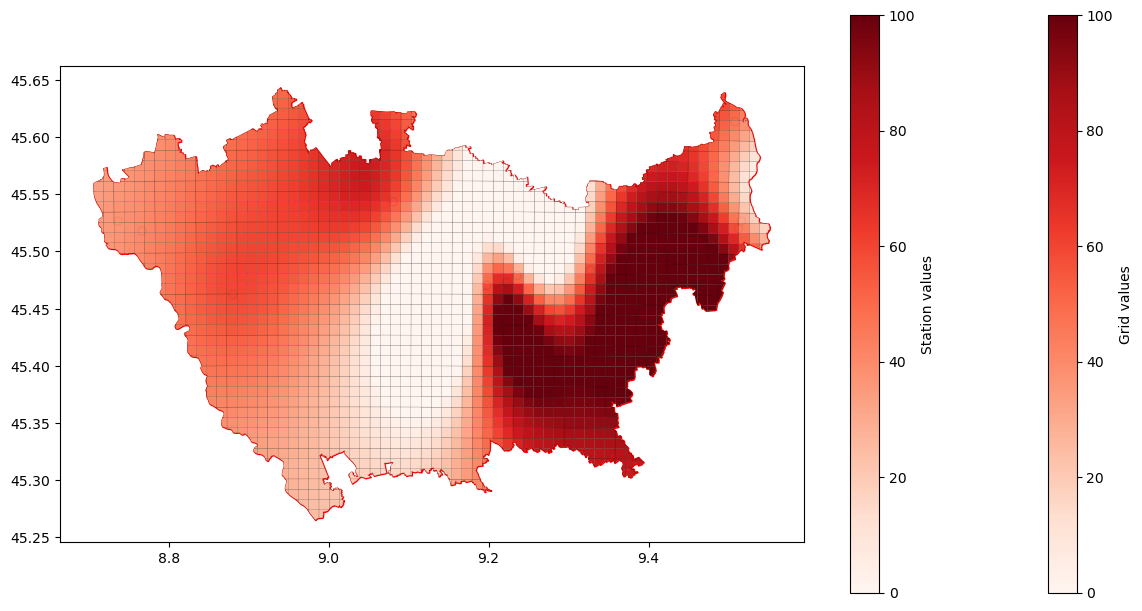

----------------------------------------------------------------------
Month 3
Creating an interpolation with the Inverse Distance Weighted method
Plotting the results...


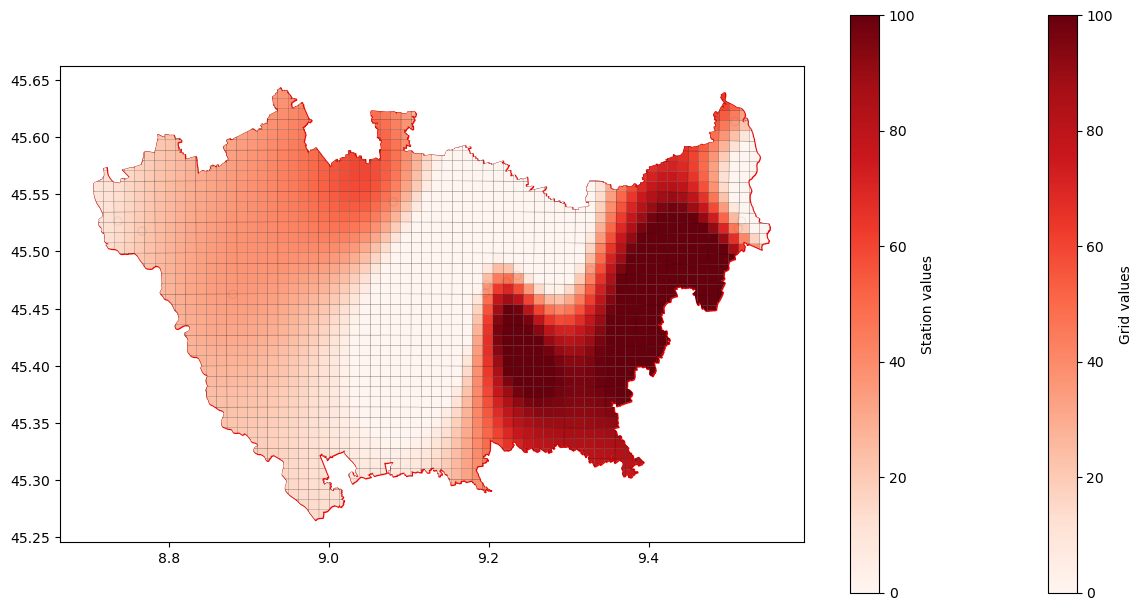

----------------------------------------------------------------------
Month 4
Creating an interpolation with the Inverse Distance Weighted method
Plotting the results...


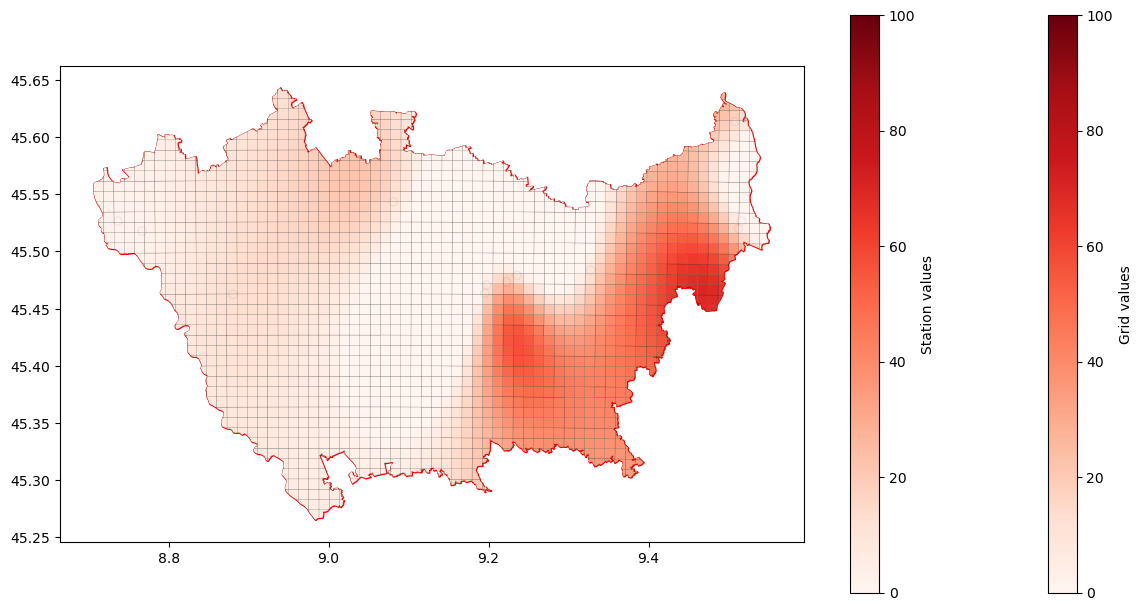

----------------------------------------------------------------------
Month 5
Creating an interpolation with the Inverse Distance Weighted method
Plotting the results...


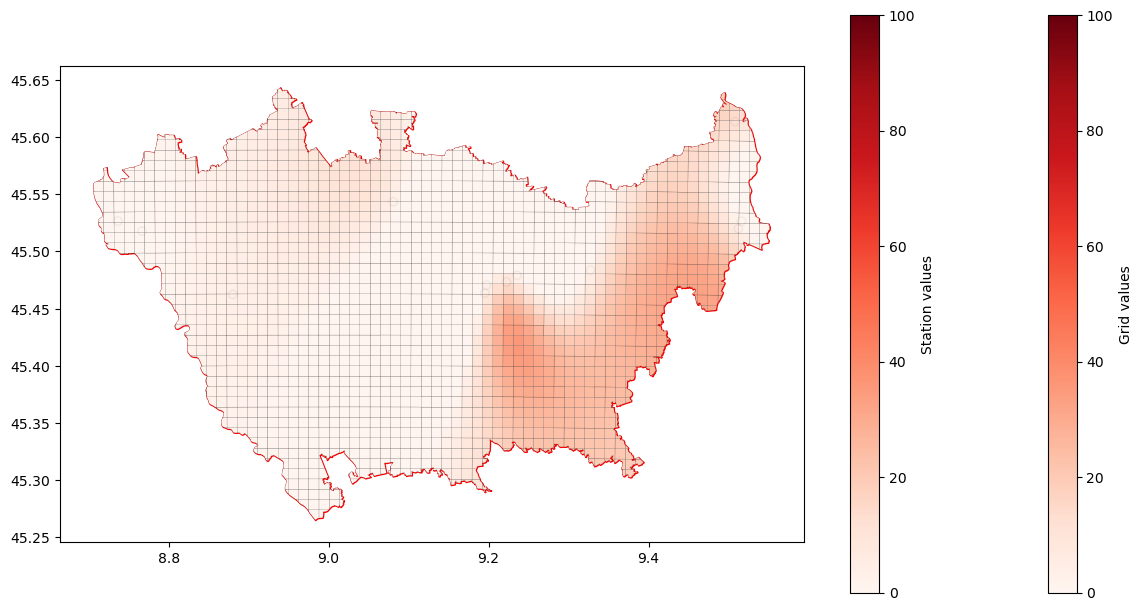

----------------------------------------------------------------------
Month 6
Creating an interpolation with the Inverse Distance Weighted method
Plotting the results...


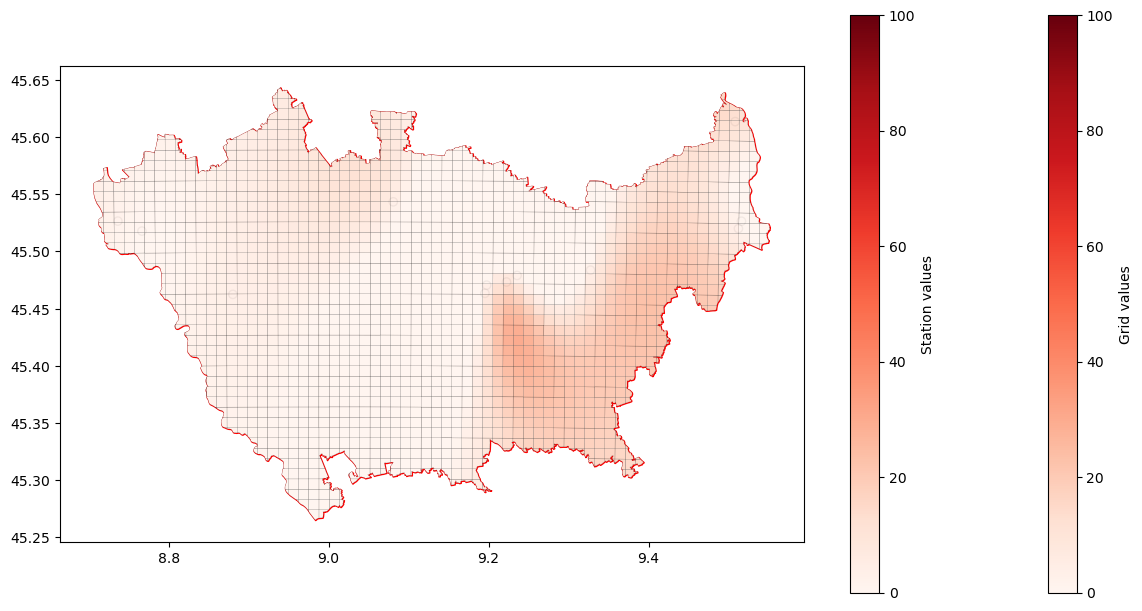

----------------------------------------------------------------------
Month 7
Creating an interpolation with the Inverse Distance Weighted method
Plotting the results...


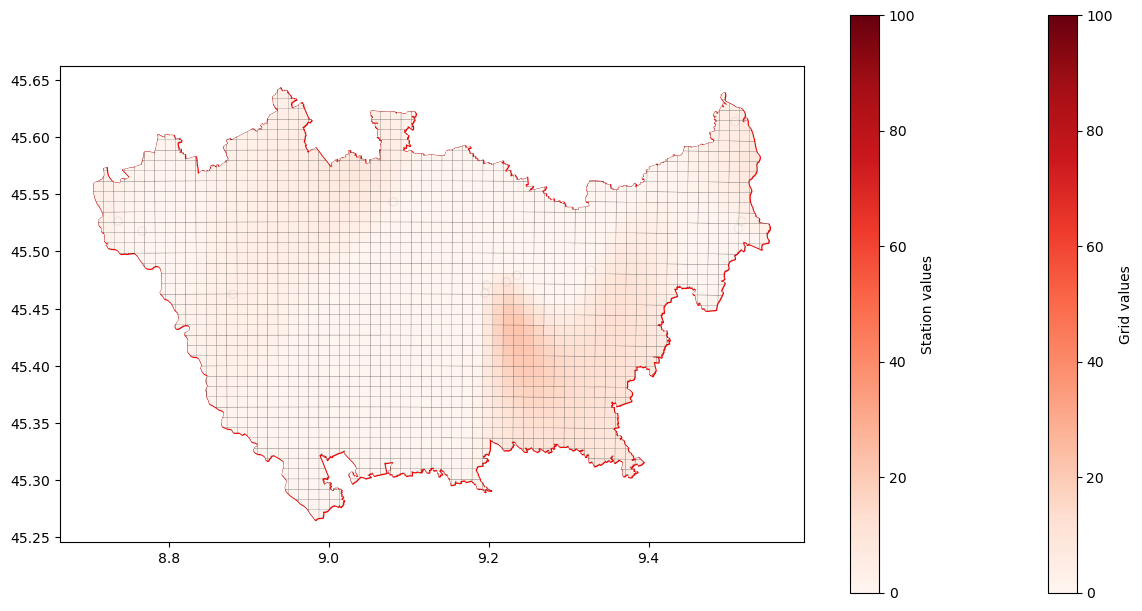

----------------------------------------------------------------------
Month 8
Creating an interpolation with the Inverse Distance Weighted method
Plotting the results...


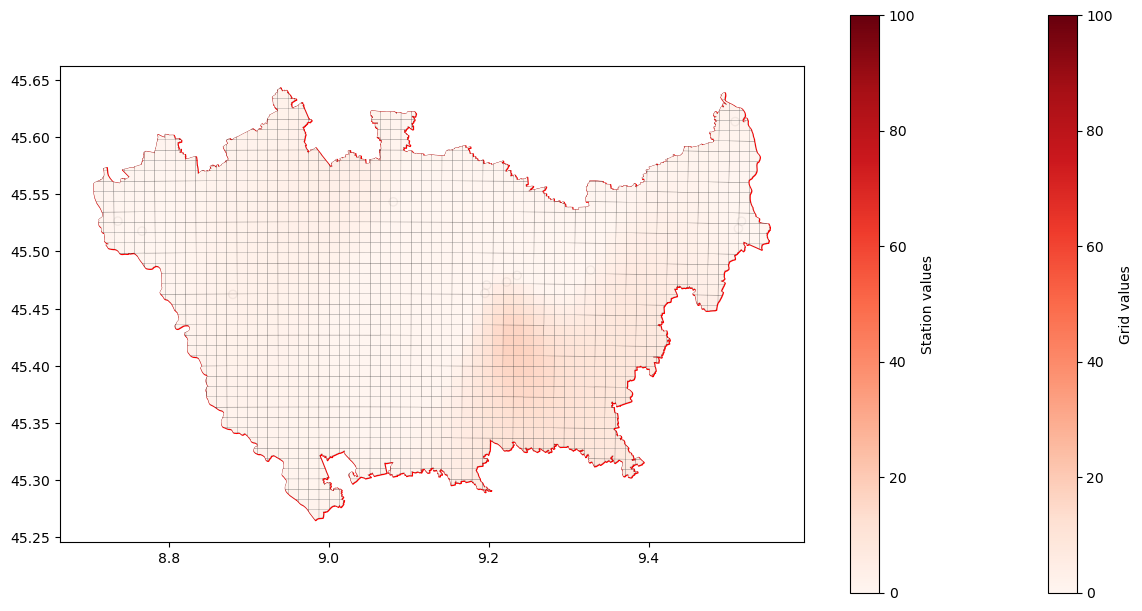

----------------------------------------------------------------------
Month 9
Creating an interpolation with the Inverse Distance Weighted method
Plotting the results...


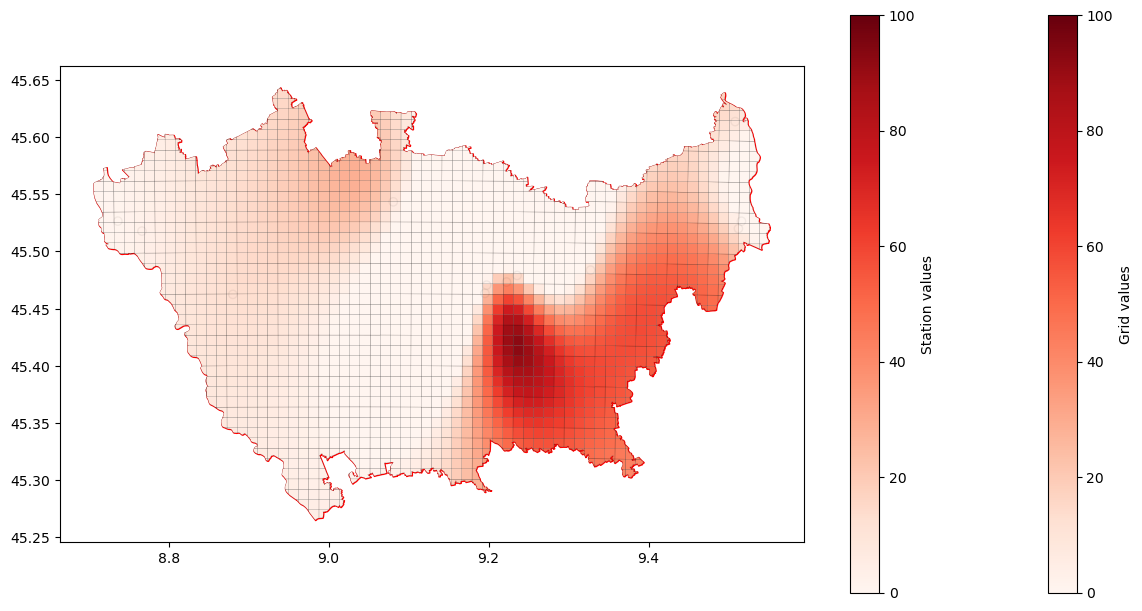

----------------------------------------------------------------------
Month 10
Creating an interpolation with the Inverse Distance Weighted method
Plotting the results...


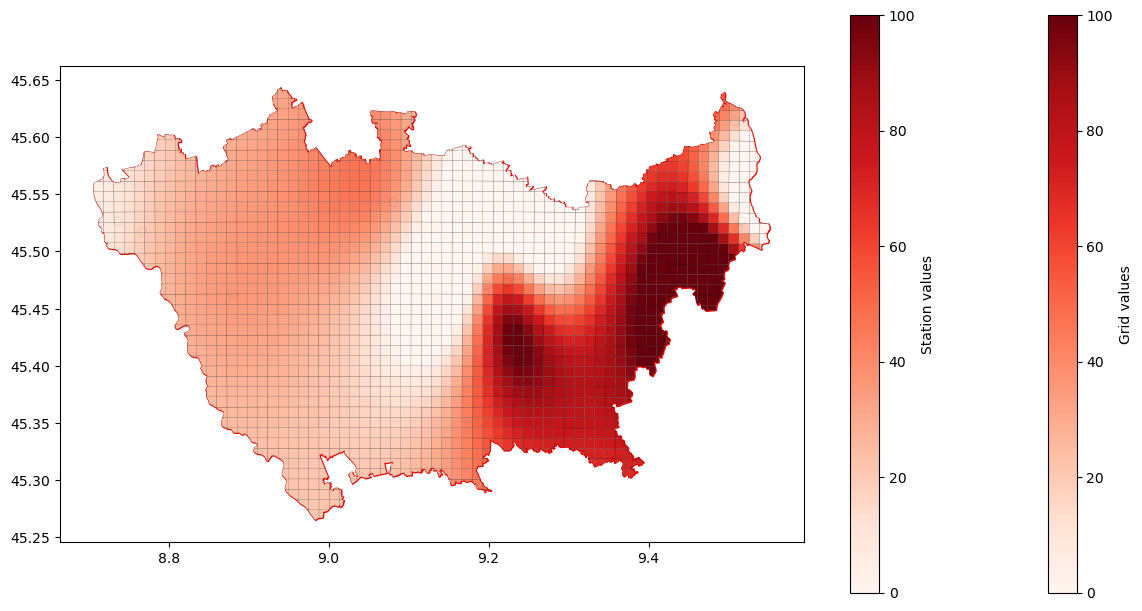

----------------------------------------------------------------------
Month 11
Creating an interpolation with the Inverse Distance Weighted method
Plotting the results...


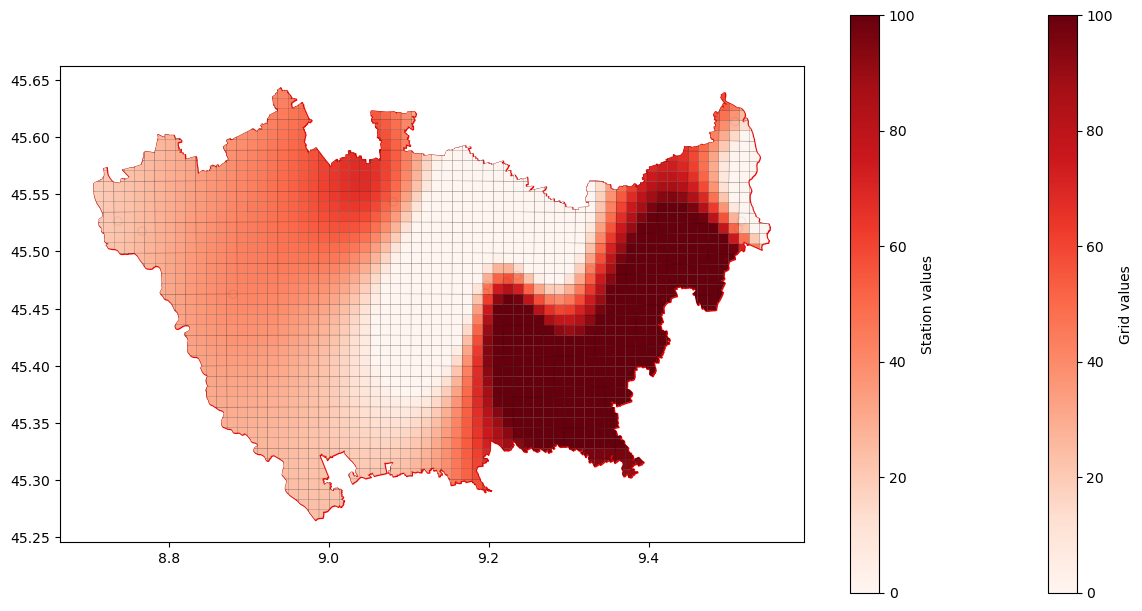

----------------------------------------------------------------------
Month 12
Creating an interpolation with the Inverse Distance Weighted method
Plotting the results...


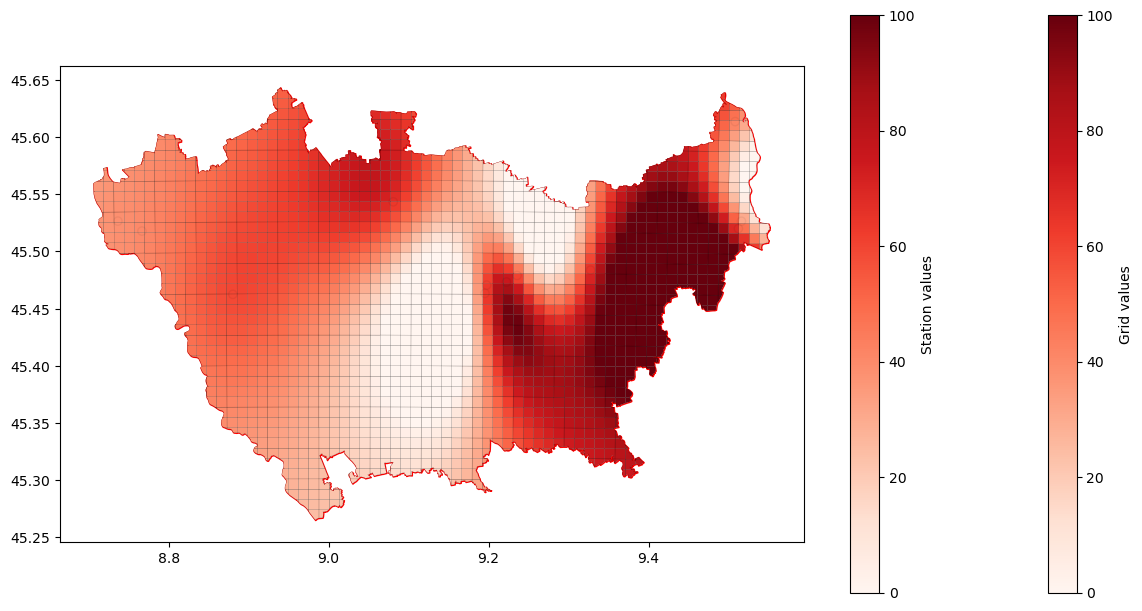

----------------------------------------------------------------------


In [18]:
#Interpolation over the map for the average exceeded rates for each month 

for month in range(1,13):
    print(f"Month {month}")
    pm10_interpolation = month_average_exceedence_rate.loc[
        (month_average_exceedence_rate['month'] == month) 
    ]
    pm10_grid, pm10_interpolation_df = interp.interpolate(
        'exceeded_rate', 
        'IDW', 
        milano_shapefile_path, 
        pm10_interpolation, 
        xdelta=xdelta, 
        ydelta=ydelta
    )
    print("----------------------------------------------------------------------")